In [10]:
import warnings
import pickle
import sys
import os
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
from datetime import date
from tqdm.auto import tqdm
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error

sys.path.append(os.path.dirname(os.getcwd()))

from s1_data_preparation.config import *
from s1_data_preparation.data_preparation import retrieve_data
from s2_crystal_ball.gaussian import fuzzifyTestset, plotGaussian
from s2_crystal_ball.fuzzy import fuzzifyTrainTest
from s2_crystal_ball.mces import mcesPipeline


## Section 1: Retrieve Data 

In [11]:
ticker = 'C38U.SI'
traindf, valdf, testdf = retrieve_data(ticker)

[*********************100%***********************]  1 of 1 completed


Columns after reset_index: Index(['Date', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object', name='Price')


## Section 2.1: Neural Networks (Fuzzification)

In [12]:
from s2_crystal_ball.config import *

In [13]:
cluster_dict = {
    'cluster_type': 'kmeans', # {kmeans, gmm}
    'min_clusters': CLUSTER_MINCLUSTERS, # 4
    'max_clusters': CLUSTER_MAXCLUSTERS, # 8
    'factor': FACTOR, # 1,
    'initial_min_datapoints': 0, # 5 
    'merger_details': {
        'merged_min_clusters': 6, # 4
        'merged_max_clusters': MERGED_MAX, # 8
        'merged_min_std': MERGED_MIN_STD, 
        'merged_maxy_clusters': MERGED_YMAX, 
        'merged_miny_std': MERGED_MINY_STD, 
    }
}

ftraindf, fvaldf, ftestdf, cluster_details = fuzzifyTrainTest(traindf, valdf, testdf, cluster_dict)

fuzzifying trainset


100%|██████████| 85/85 [00:55<00:00,  1.53it/s]


fuzzifying testset


100%|██████████| 85/85 [00:02<00:00, 32.12it/s]


fuzzifying valset


100%|██████████| 85/85 [00:01<00:00, 70.03it/s]


In [14]:
import pickle
import pandas as pd

ftraindf.to_csv(f'data/{ticker}/ftraindf.csv')
fvaldf.to_csv(f'data/{ticker}/fvaldf.csv')
ftestdf.to_csv(f'data/{ticker}/ftestdf.csv')
with open(f'data/{ticker}/cluster_details.pkl', 'wb') as fp: 
    pickle.dump(cluster_details, fp)

In [15]:
ftraindf = pd.read_csv(f'data/{ticker}/ftraindf.csv', index_col = 'Date')
fvaldf = pd.read_csv(f'data/{ticker}/fvaldf.csv', index_col = 'Date')
ftestdf = pd.read_csv(f'data/{ticker}/ftestdf.csv', index_col = 'Date')
with open(f'data/{ticker}/cluster_details.pkl', 'rb') as handle:
    cluster_details = pickle.load(handle)

In [16]:
# plotGaussian(cluster_details, plot_x = 1)

In [17]:
# plotGaussian(cluster_details, plot_x = 0, plotrange = (-1, 1))

In [18]:
print(type(cluster_details))
print(cluster_details.keys())


<class 'dict'>
dict_keys(['High', 'Low', 'Open', 'x_Tm1_PriceChg', 'x_Tm1_VolChg', 'x_Tm1_PRoc1', 'x_Tm2_PriceChg', 'x_Tm2_VolChg', 'x_Tm2_PRoc1', 'x_Tm3_PriceChg', 'x_Tm3_VolChg', 'x_Tm3_PRoc1', 'x_Tm4_PriceChg', 'x_Tm4_VolChg', 'x_Tm4_PRoc1', 'x_Tm5_PriceChg', 'x_Tm5_VolChg', 'x_Tm5_PRoc1', 'x_Tm6_PriceChg', 'x_Tm6_VolChg', 'x_Tm6_PRoc1', 'x_Tm7_PriceChg', 'x_Tm7_VolChg', 'x_Tm7_PRoc1', 'x_Tm8_PriceChg', 'x_Tm8_VolChg', 'x_Tm8_PRoc1', 'x_Tm9_PriceChg', 'x_Tm9_VolChg', 'x_Tm9_PRoc1', 'x_Tm10_PriceChg', 'x_Tm10_VolChg', 'x_Tm10_PRoc1', 'x_Tm11_PriceChg', 'x_Tm11_VolChg', 'x_Tm11_PRoc1', 'x_Tm12_PriceChg', 'x_Tm12_VolChg', 'x_Tm12_PRoc1', 'x_Tm13_PriceChg', 'x_Tm13_VolChg', 'x_Tm13_PRoc1', 'y_Tp1_PriceChg', 'y_Tp2_PriceChg', 'y_Tp3_PriceChg', 'y_Tp4_PriceChg', 'y_Tp5_PriceChg', 'y_Tp6_PriceChg', 'y_Tp7_PriceChg', 'y_Tp8_PriceChg', 'y_Tp9_PriceChg', 'y_Tp10_PriceChg', 'y_Tp11_PriceChg', 'y_Tp12_PriceChg', 'y_Tp13_PriceChg'])


In [22]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
def evaluate_kmeans_clustering(fdf, n_clusters):
    # Drop non-numeric columns (like date or object columns)
    numeric_df = fdf.select_dtypes(include=[np.number])  # Only keep numeric features

    model = KMeans(n_clusters=n_clusters, random_state=42)
    labels = model.fit_predict(numeric_df)

    silhouette = silhouette_score(numeric_df, labels)
    calinski = calinski_harabasz_score(numeric_df, labels)
    davies = davies_bouldin_score(numeric_df, labels)

    return {
        "Silhouette Score": silhouette,
        "Calinski-Harabasz Index": calinski,
        "Davies-Bouldin Index": davies
    }

# Try again
metrics = evaluate_kmeans_clustering(ftraindf, n_clusters=6)

print("Cluster Performance Metrics:")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")


Cluster Performance Metrics:
Silhouette Score: 0.0486
Calinski-Harabasz Index: 132.4387
Davies-Bouldin Index: 3.3895


In [23]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.cluster import KMeans
import numpy as np

# Load your fuzzified train data
rtraindf = pd.read_csv("/home/priya/Desktop/fyp/Src alwin/Src/data/C38U.SI/Tp13/rftraindf.csv", index_col='Date')

def evaluate_cluster_predictive_power(fdf, n_clusters, target_col='y_Tp1_PriceChg'):
    # Prepare data
    numeric_df = fdf.select_dtypes(include=[np.number]).drop(columns=[target_col], errors='ignore')
    target = fdf[target_col]

    # KMeans clustering
    model = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = model.fit_predict(numeric_df)

    # One-hot encode clusters to use as features
    cluster_features = pd.get_dummies(cluster_labels)

    # Fit regression model using clusters to predict target
    reg = LinearRegression()
    reg.fit(cluster_features, target)
    preds = reg.predict(cluster_features)

    r2 = r2_score(target, preds)
    rmse = np.sqrt(mean_squared_error(target, preds))

    return {
        "R² Score": r2,
        "RMSE": rmse
    }

regression_metrics = evaluate_cluster_predictive_power(rtraindf, n_clusters=6, target_col='ypcref_Tp1_PriceChg')

print("Cluster Predictive Power on Target:")
for k, v in regression_metrics.items():
    print(f"{k}: {v:.4f}")



Cluster Predictive Power on Target:
R² Score: 0.0115
RMSE: 0.0653


In [24]:
print(rtraindf.columns.tolist())
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, silhouette_score
from sklearn.cluster import KMeans

# Load your data
rtraindf = pd.read_csv("/home/priya/Desktop/fyp/Src alwin/Src/data/C38U.SI/Tp13/rftraindf.csv", index_col='Date')

# Config
target_col = 'ypcref_Tp1_PriceChg'
n_clusters = 6

# Prepare inputs
numeric_df = rtraindf.select_dtypes(include=[np.number]).drop(columns=[target_col], errors='ignore')
target = rtraindf[target_col]

# Fit KMeans
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(numeric_df)
sil_score = silhouette_score(numeric_df, cluster_labels)

results = {}

# 1. ✅ All fuzzy features
reg_all = LinearRegression()
reg_all.fit(numeric_df, target)
pred_all = reg_all.predict(numeric_df)
results['All Fuzzy Features'] = {
    'R²': r2_score(target, pred_all),
    'RMSE': np.sqrt(mean_squared_error(target, pred_all))
}

# 2. 🟡 Only cluster one-hot
cluster_onehot = pd.get_dummies(cluster_labels)
reg_cluster = LinearRegression()
reg_cluster.fit(cluster_onehot, target)
pred_cluster = reg_cluster.predict(cluster_onehot)
results['Cluster One-Hot Only'] = {
    'R²': r2_score(target, pred_cluster),
    'RMSE': np.sqrt(mean_squared_error(target, pred_cluster))
}

# 3. 🧩 All fuzzy + cluster ID
with_cluster = numeric_df.copy()
with_cluster['cluster'] = cluster_labels
reg_combo = LinearRegression()
reg_combo.fit(with_cluster, target)
pred_combo = reg_combo.predict(with_cluster)
results['Fuzzy + Cluster ID'] = {
    'R²': r2_score(target, pred_combo),
    'RMSE': np.sqrt(mean_squared_error(target, pred_combo))
}

# Print results
print(f"Silhouette Score: {sil_score:.4f}\n")
print("🔍 Regression Performance Comparison:")
for name, metrics in results.items():
    print(f"\n{name}")
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.4f}")


['x_Tm12_VolChg_c0', 'x_Tm12_VolChg_c1', 'x_Tm12_VolChg_c2', 'x_Tm12_VolChg_c3', 'x_Tm12_VolChg_c4', 'x_Tm12_VolChg_c5', 'x_Tm12_VolChg_c6', 'x_Tm4_PRoc1_c0', 'x_Tm4_PRoc1_c1', 'x_Tm4_PRoc1_c2', 'x_Tm4_PRoc1_c3', 'x_Tm4_PRoc1_c4', 'x_Tm4_PRoc1_c5', 'x_Tm4_PRoc1_c6', 'x_Tm1_PriceChg_c0', 'x_Tm1_PriceChg_c1', 'x_Tm1_PriceChg_c2', 'x_Tm1_PriceChg_c3', 'x_Tm1_PriceChg_c4', 'x_Tm1_PriceChg_c5', 'x_Tm1_PriceChg_c6', 'x_Tm3_PriceChg_c0', 'x_Tm3_PriceChg_c1', 'x_Tm3_PriceChg_c2', 'x_Tm3_PriceChg_c3', 'x_Tm3_PriceChg_c4', 'x_Tm3_PriceChg_c5', 'x_Tm3_PriceChg_c6', 'x_Tm1_PRoc1_c0', 'x_Tm1_PRoc1_c1', 'x_Tm1_PRoc1_c2', 'x_Tm1_PRoc1_c3', 'x_Tm1_PRoc1_c4', 'x_Tm1_PRoc1_c5', 'x_Tm1_PRoc1_c6', 'x_Tm5_VolChg_c0', 'x_Tm5_VolChg_c1', 'x_Tm5_VolChg_c2', 'x_Tm5_VolChg_c3', 'x_Tm5_VolChg_c4', 'x_Tm5_VolChg_c5', 'x_Tm5_VolChg_c6', 'x_Tm6_PRoc1_c0', 'x_Tm6_PRoc1_c1', 'x_Tm6_PRoc1_c2', 'x_Tm6_PRoc1_c3', 'x_Tm6_PRoc1_c4', 'x_Tm6_PRoc1_c5', 'x_Tm6_PRoc1_c6', 'x_Tm13_PRoc1_c0', 'x_Tm13_PRoc1_c1', 'x_Tm13_PRoc1_c2


🌀 Silhouette Score from clustering: 0.3155

📊 Plotting R² comparison:


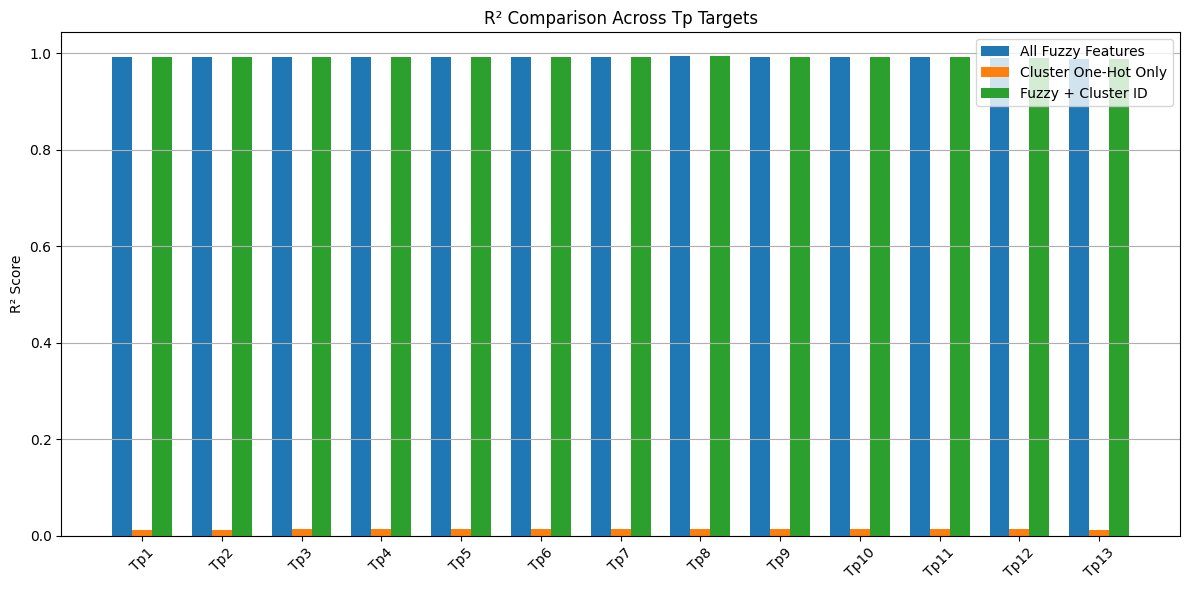

📊 Plotting RMSE comparison:


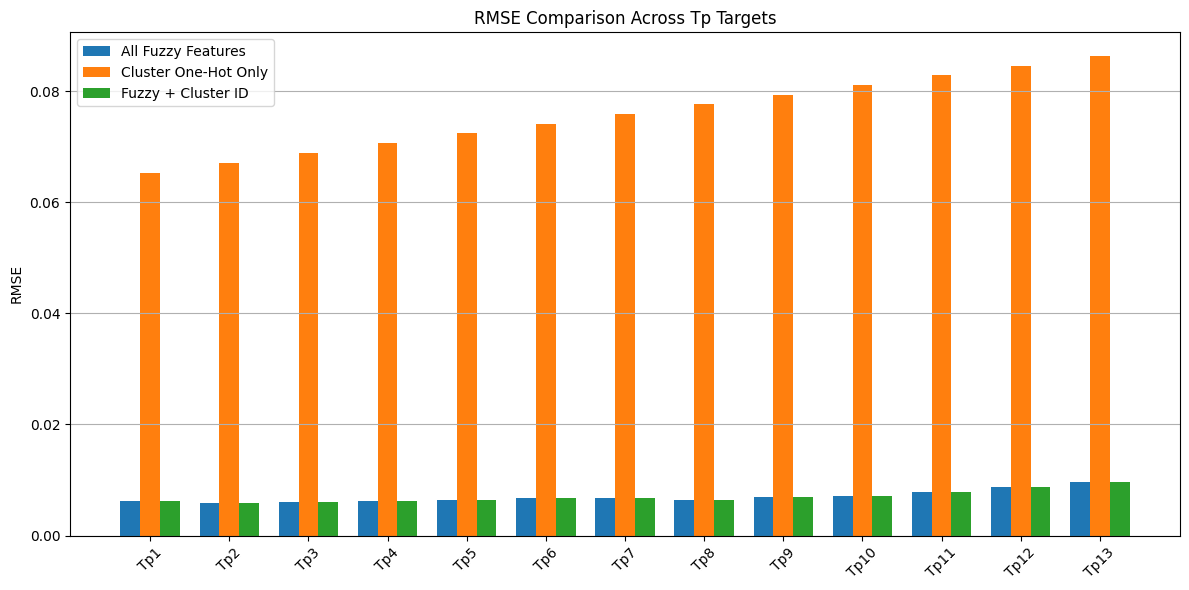

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, silhouette_score
from sklearn.cluster import KMeans

# Load your data
rtraindf = pd.read_csv("/home/priya/Desktop/fyp/Src alwin/Src/data/C38U.SI/Tp13/rftraindf.csv", index_col='Date')

# Extract numeric data and build clusters once
numeric_df = rtraindf.select_dtypes(include=[np.number]).copy()
target_cols = [f'ypcref_Tp{i}_PriceChg' for i in range(1, 14) if f'ypcref_Tp{i}_PriceChg' in numeric_df.columns]

# Remove all possible targets from feature set
feature_df = numeric_df.drop(columns=target_cols, errors='ignore')

# Clustering (once for all targets)
n_clusters = 6
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(feature_df)
sil_score = silhouette_score(feature_df, cluster_labels)

# Store results
r2_results = {'All Fuzzy Features': [], 'Cluster One-Hot Only': [], 'Fuzzy + Cluster ID': []}
rmse_results = {'All Fuzzy Features': [], 'Cluster One-Hot Only': [], 'Fuzzy + Cluster ID': []}

# Evaluate across all targets
for target_col in target_cols:
    target = numeric_df[target_col]

    # Model 1: All fuzzy features
    reg_all = LinearRegression()
    reg_all.fit(feature_df, target)
    pred_all = reg_all.predict(feature_df)
    r2_results['All Fuzzy Features'].append(r2_score(target, pred_all))
    rmse_results['All Fuzzy Features'].append(np.sqrt(mean_squared_error(target, pred_all)))

    # Model 2: Cluster one-hot
    cluster_onehot = pd.get_dummies(cluster_labels)
    reg_cluster = LinearRegression()
    reg_cluster.fit(cluster_onehot, target)
    pred_cluster = reg_cluster.predict(cluster_onehot)
    r2_results['Cluster One-Hot Only'].append(r2_score(target, pred_cluster))
    rmse_results['Cluster One-Hot Only'].append(np.sqrt(mean_squared_error(target, pred_cluster)))

    # Model 3: All fuzzy + cluster ID
    with_cluster = feature_df.copy()
    with_cluster['cluster'] = cluster_labels
    reg_combo = LinearRegression()
    reg_combo.fit(with_cluster, target)
    pred_combo = reg_combo.predict(with_cluster)
    r2_results['Fuzzy + Cluster ID'].append(r2_score(target, pred_combo))
    rmse_results['Fuzzy + Cluster ID'].append(np.sqrt(mean_squared_error(target, pred_combo)))

# -------- PLOTTING --------

tp_labels = [f'Tp{i}' for i in range(1, len(target_cols) + 1)]
x = np.arange(len(tp_labels))
width = 0.25

def plot_metric(metric_dict, ylabel, title):
    plt.figure(figsize=(12, 6))
    for idx, (label, scores) in enumerate(metric_dict.items()):
        plt.bar(x + idx * width, scores, width=width, label=label)
    plt.xticks(x + width, tp_labels, rotation=45)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

print(f"\n🌀 Silhouette Score from clustering: {sil_score:.4f}")

print("\n📊 Plotting R² comparison:")
plot_metric(r2_results, ylabel="R² Score", title="R² Comparison Across Tp Targets")

print("📊 Plotting RMSE comparison:")
plot_metric(rmse_results, ylabel="RMSE", title="RMSE Comparison Across Tp Targets")


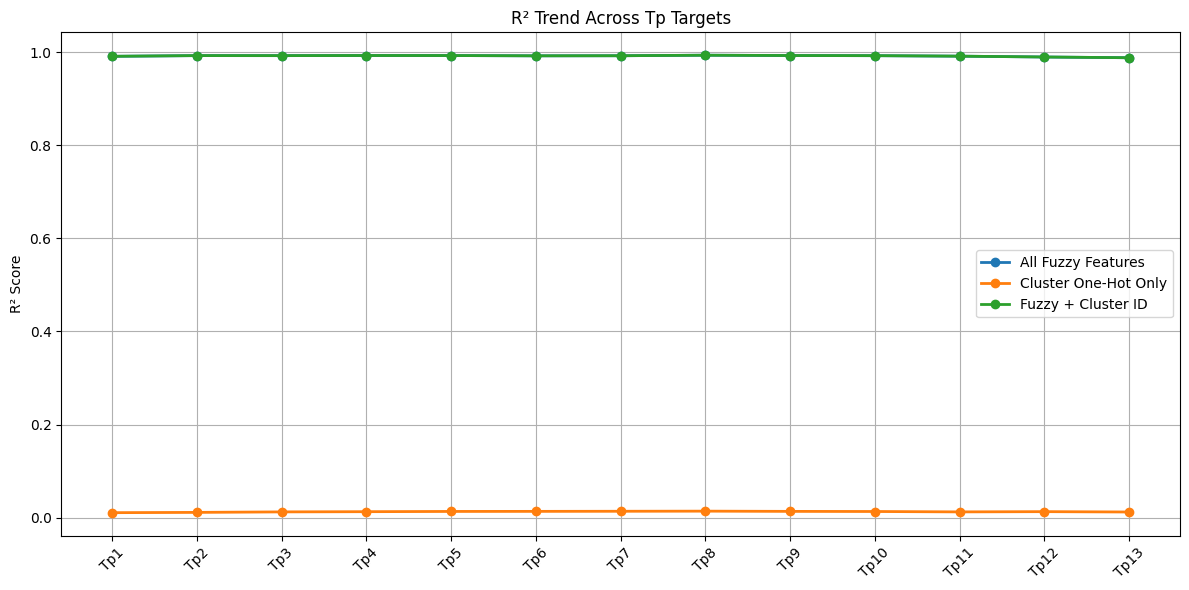

In [26]:
def plot_r2_line(metric_dict):
    plt.figure(figsize=(12, 6))
    for label, scores in metric_dict.items():
        plt.plot(tp_labels, scores, marker='o', label=label, linewidth=2)
    plt.xticks(rotation=45)
    plt.ylabel("R² Score")
    plt.title("R² Trend Across Tp Targets")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_r2_line(r2_results)


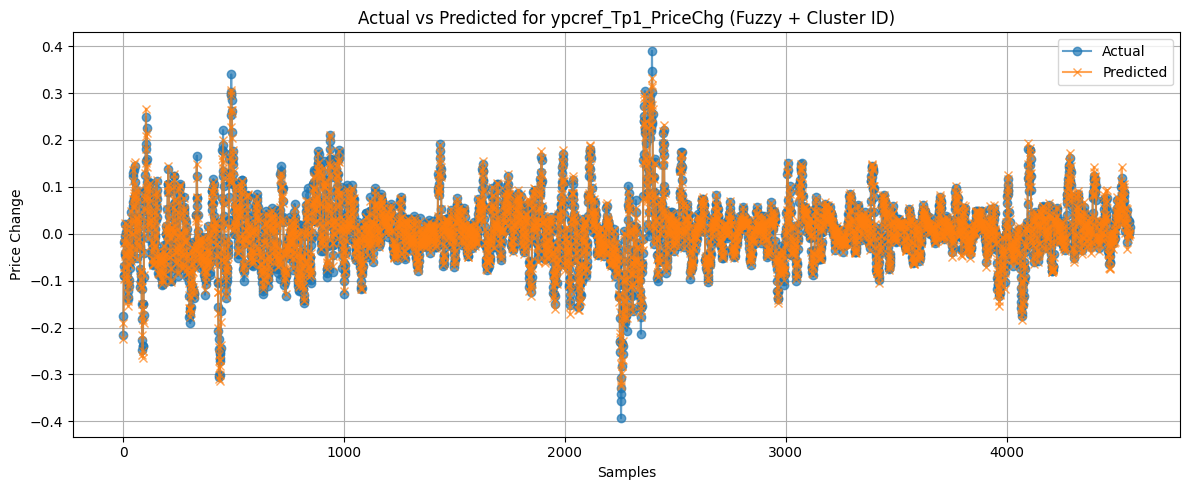

In [27]:
import matplotlib.pyplot as plt

# Choose target to visualize
target_col = 'ypcref_Tp1_PriceChg'
target = numeric_df[target_col]

# Reuse fuzzy + cluster model
with_cluster = feature_df.copy()
with_cluster['cluster'] = cluster_labels

reg = LinearRegression()
reg.fit(with_cluster, target)
preds = reg.predict(with_cluster)

# Plot
plt.figure(figsize=(12, 5))
plt.plot(target.values, label="Actual", marker='o', alpha=0.7)
plt.plot(preds, label="Predicted", marker='x', alpha=0.7)
plt.title(f"Actual vs Predicted for {target_col} (Fuzzy + Cluster ID)")
plt.xlabel("Samples")
plt.ylabel("Price Change")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# import os
# import pickle
# import pandas as pd
# from s1_data_preparation.data_preparation import retrieve_data
# from s2_crystal_ball.fuzzy import fuzzifyTrainTest
# from s1_data_preparation.config import *
# from s2_crystal_ball.config import *

# # Ticker dictionary
# tickers = {
#     # "Q0F.SI": "IHH Healthcare",
#     # "S68.SI": "SGX",
#     # "S63.SI": "ST Engineering",
#     # "AJBU.SI": "Keppel DC REIT"
#     "D05.SI": "DBS bank"}

# # Cluster configuration
# cluster_dict = {
#     'cluster_type': 'kmeans',
#     'min_clusters': CLUSTER_MINCLUSTERS,
#     'max_clusters': CLUSTER_MAXCLUSTERS,
#     'factor': FACTOR,
#     'initial_min_datapoints': 0,
#     'merger_details': {
#         'merged_min_clusters': 6,
#         'merged_max_clusters': MERGED_MAX,
#         'merged_min_std': MERGED_MIN_STD,
#         'merged_maxy_clusters': MERGED_YMAX,
#         'merged_miny_std': MERGED_MINY_STD,
#     }
# }

# # Create output folders if they don't exist
# os.makedirs("data", exist_ok=True)

# # Loop through all tickers
# for ticker in tickers:
#     print(f"\nProcessing: {ticker} - {tickers[ticker]}")
#     os.makedirs(f"data/{ticker}", exist_ok=True)

#     try:
#         traindf, valdf, testdf = retrieve_data(ticker)
#         ftraindf, fvaldf, ftestdf, cluster_details = fuzzifyTrainTest(traindf, valdf, testdf, cluster_dict)

#         ftraindf.to_csv(f'data/{ticker}/ftraindf.csv')
#         fvaldf.to_csv(f'data/{ticker}/fvaldf.csv')
#         ftestdf.to_csv(f'data/{ticker}/ftestdf.csv')

#         with open(f'data/{ticker}/cluster_details.pkl', 'wb') as fp:
#             pickle.dump(cluster_details, fp)

#         print(f"Completed: {ticker}")

#     except Exception as e:
#         print(f"Failed for {ticker}: {e}")



Processing: D05.SI - DBS bank


[*********************100%***********************]  1 of 1 completed


Columns after reset_index: Index(['Date', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object', name='Price')
fuzzifying trainset


 15%|█▌        | 13/85 [00:20<01:28,  1.23s/it]